# VOC Dataloader

## Imports

In [1]:
import math
import numpy as np
import cv2

import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

## Loader

In [2]:
def replace_tensor_value_(tensor, a, b):
    tensor[tensor == a] = b
    return tensor

def plot_images(images, num_per_row=4, title=None):
    num_rows = int(math.ceil(len(images) / num_per_row))

    fig, axes = plt.subplots(num_rows, num_per_row, dpi=256)
    fig.subplots_adjust(wspace=0, hspace=0)

    for image, ax in zip(images, axes.flat):
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    return fig

In [3]:
input_resize = transforms.Resize((256, 256))
input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
    ]
)


target_resize = transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST)
target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
        # transforms.Lambda(lambda x: replace_tensor_value_(x.squeeze(0).long(), 255, 21)),
    ]
)

In [4]:
# Creating a VOC dataset without normalization for visualization.
train_dataset_viz = datasets.VOCSegmentation(
    'data',
    year='2012',
    image_set='train',
    transform=input_resize,
    target_transform=target_resize,
)

In [5]:
batch_size = 16
inputs, ground_truths = map(list, zip(*[train_dataset_viz[i+256+12*16] for i in range(batch_size)]))

## Plots

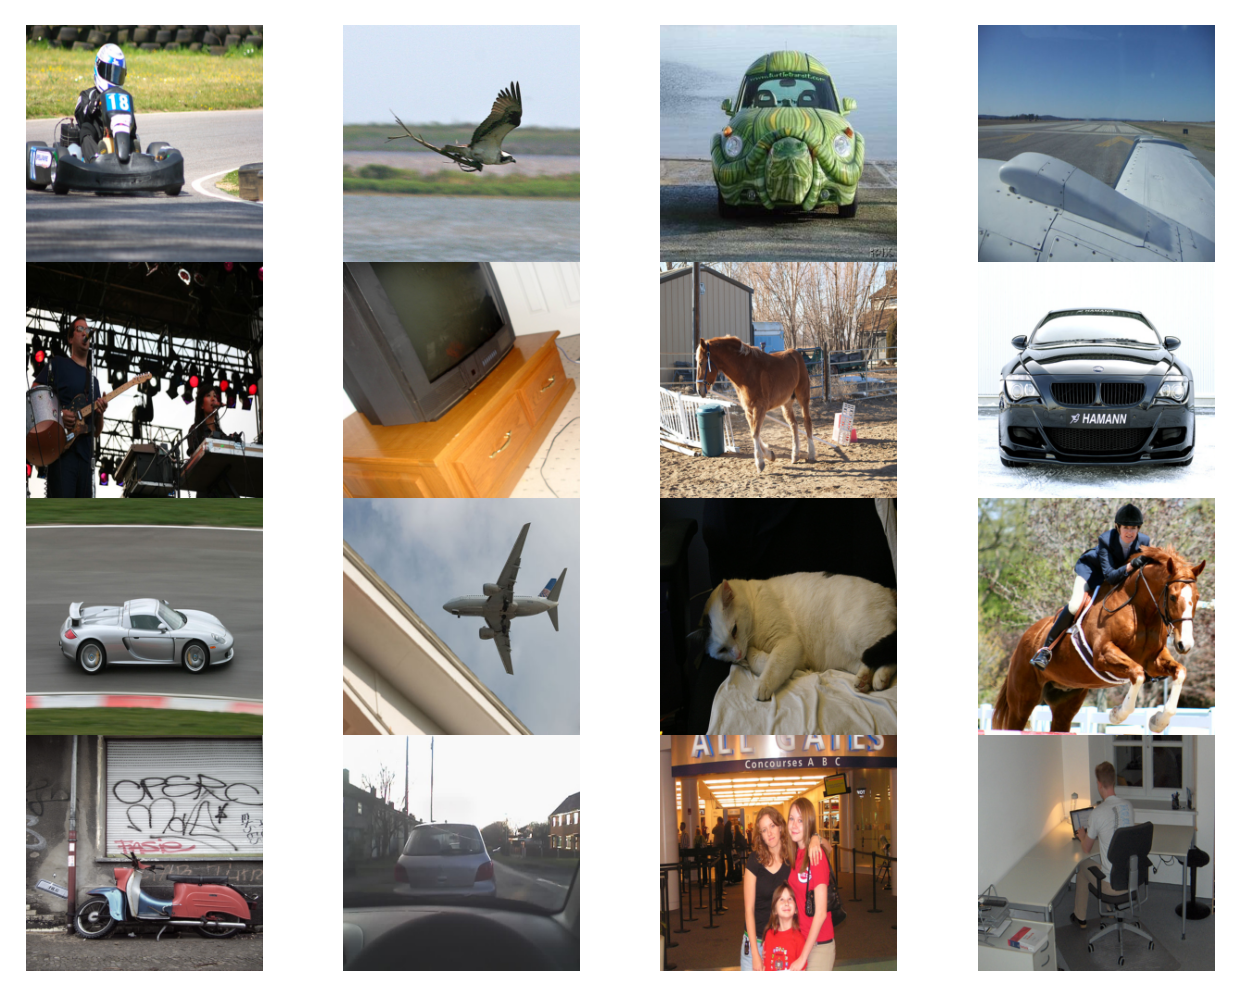

In [6]:
_ = plot_images(inputs)

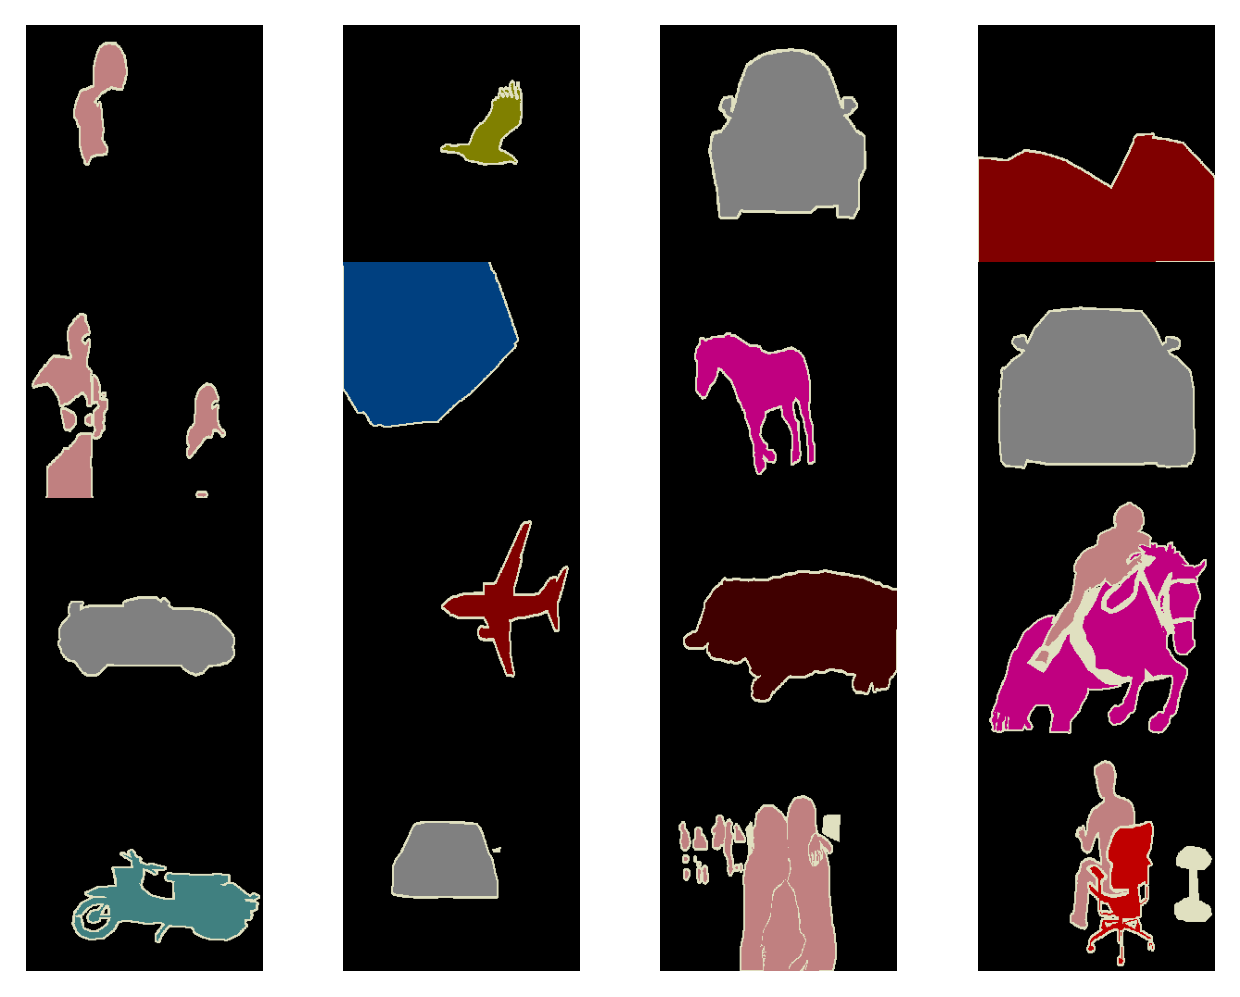

In [7]:
_ = plot_images(ground_truths)

# Foveated Vision

## Imports

In [8]:
from fovperi.fov.fov2 import getFov, reverseMapPixel, reverseMapPixel_Initial, generate_fovea 

## Foveation code

In [9]:
# Foveation
N, p0, Nr = [256, 22, 18]
fovCenter = int( ( N - 2*p0 ) / 2 )

bio_foveation = True
add_coords = False

In [10]:
# generate_fovea(N, p0, Nr)

In [11]:
reverseMapPixel_Initial = reverseMapPixel_Initial( N=N, p0=p0, Nr=Nr, fovCenter=fovCenter, bio=bio_foveation )
reverseMapPixel = reverseMapPixel( N=N, p0=p0, Nr=Nr, bio=bio_foveation )
getFovead = getFov( N=N, p0=p0, Nr=Nr, bio=bio_foveation, add_coords=add_coords )
fovSize = 2 * ( p0 + Nr ) + 1

In [13]:
from PIL import Image

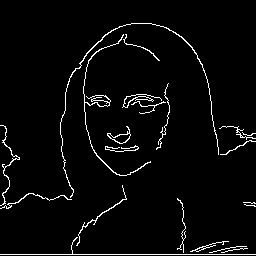

In [16]:
i = 15

# open image 
sample_image = Image.open(r'data\mona_lisa\1.png')
# Crop to square and Resize to 256 x 256
# Crop to square
width, height = sample_image.size
left = 0
top = 0
right = width
bottom = width + top

sample_image = sample_image.crop((left, top, right, bottom))

# Resize to 256 x 256
sample_image = sample_image.resize((256, 256))

# For sample_labels do canny edge detection
sample_labels = Image.fromarray(cv2.Canny(np.array(sample_image), 400, 150))

sample_labels

In [17]:
sample_image = np.array(sample_image)[:,:,:3]
sample_labels = np.array(sample_labels)

# # Add dimension
sample_labels = np.expand_dims(sample_labels, axis=2)

In [19]:
sample_image

array([[[108, 108,  80],
        [109, 108,  76],
        [116, 115,  77],
        [121, 121,  83],
        [112, 112,  75],
        [106, 106,  71],
        [107, 107,  74],
        [105, 107,  73],
        [ 98, 102,  67],
        [ 95,  99,  64],
        [103, 107,  71],
        [104, 108,  72],
        [ 99, 102,  67],
        [ 94,  97,  66],
        [ 92,  95,  66],
        [ 97, 101,  70],
        [106, 106,  76],
        [118, 112,  86],
        [115, 112,  84],
        [106, 104,  76],
        [109, 108,  80],
        [116, 113,  86],
        [108, 107,  79],
        [100,  99,  71],
        [101, 101,  72],
        [ 94,  98,  67],
        [ 96, 101,  69],
        [103, 105,  75],
        [105, 104,  75],
        [116, 114,  83],
        [123, 121,  87],
        [126, 124,  91],
        [124, 121,  90],
        [117, 115,  85],
        [112, 110,  80],
        [110, 109,  80],
        [108, 107,  77],
        [106, 105,  74],
        [105, 103,  72],
        [100,  97,  64],


In [18]:
# fovX, fovY will be the left upper corner of the foveated image
fovX, fovY = sample_image.shape[1] // 2 - p0 , sample_image.shape[0] // 2 - p0 
foveated_image = getFovead(sample_image, fovX=fovX, fovY=fovY, add_coords=add_coords)
reconstructed, interpolated = getFovead(foveated_image, fovX=fovX, fovY=fovY, add_coords=add_coords, reverse=True)

foveated_labels = getFovead(sample_labels, fovX=fovX, fovY=fovY, add_coords=False)
reconstructed_labels, interpolated_labels = getFovead(foveated_labels, fovX=fovX, fovY=fovY, add_coords=False, reverse=True)

# remove the added dimension
sample_labels = np.squeeze(sample_labels, axis=2)

# Keep only one dim (remove 3 channels)
foveated_labels = np.squeeze(foveated_labels[:, :, :1], axis=2)
reconstructed_labels = np.squeeze(reconstructed_labels[:, :, :1], axis=2)
interpolated_labels = np.squeeze(interpolated_labels[:, :, :1], axis=2)

(81, 81, 3)
(6561,)
(81, 81, 3)
(6561,)


In [19]:
# pad the foveated images to the same size as the original sample image
foveated_image_padded = np.pad(foveated_image, (((sample_image.shape[0] - foveated_image.shape[0])//2, (sample_image.shape[0] - foveated_image.shape[0])//2), ((sample_image.shape[1] - foveated_image.shape[1])//2, (sample_image.shape[1] - foveated_image.shape[1])//2), (0, 0)), mode='constant', constant_values=0)
foveated_labels_padded = np.pad(foveated_labels, (((sample_labels.shape[0] - foveated_labels.shape[0])//2, (sample_labels.shape[0] - foveated_labels.shape[0])//2), ((sample_labels.shape[1] - foveated_labels.shape[1])//2, (sample_labels.shape[1] - foveated_labels.shape[1])//2)), mode='constant', constant_values=0)

In [20]:
# Normal resize for the reconstructed image
naive_resize_label = cv2.resize(np.array(sample_labels), (foveated_labels.shape[1], foveated_labels.shape[0]), interpolation=cv2.INTER_NEAREST)
naive_resize_image = cv2.resize(np.array(sample_image), (foveated_image.shape[1], foveated_image.shape[0]), interpolation=cv2.INTER_LINEAR)

# Padding
naive_resize_label_padded = np.pad(naive_resize_label, (((sample_labels.shape[0] - naive_resize_label.shape[0])//2, (sample_labels.shape[0] - naive_resize_label.shape[0])//2), ((sample_labels.shape[1] - naive_resize_label.shape[1])//2, (sample_labels.shape[1] - naive_resize_label.shape[1])//2)), mode='constant', constant_values=0)
naive_resize_image_padded = np.pad(naive_resize_image, (((sample_image.shape[0] - naive_resize_image.shape[0])//2, (sample_image.shape[0] - naive_resize_image.shape[0])//2), ((sample_image.shape[1] - naive_resize_image.shape[1])//2, (sample_image.shape[1] - naive_resize_image.shape[1])//2), (0, 0)), mode='constant', constant_values=0)

# Upscale the naive resize to the original image size
naive_upscale_label = cv2.resize(naive_resize_label, (sample_labels.shape[1], sample_labels.shape[0]), interpolation=cv2.INTER_AREA)
naive_upscale_image = cv2.resize(naive_resize_image, (sample_image.shape[1], sample_image.shape[0]), interpolation=cv2.INTER_LINEAR)

# dtype=np.uint8
naive_upscale_label = np.array(naive_upscale_label, dtype=np.uint8)

In [21]:
# dtype of sample labels
sample_labels = np.array(sample_labels, dtype=np.uint8)
reconstructed_labels = np.array(reconstructed_labels, dtype=np.uint8)
foveated_labels_padded = np.array(foveated_labels_padded, dtype=np.uint8)
interpolated_labels = np.array(interpolated_labels, dtype=np.uint8)
naive_resize_label_padded = np.array(naive_resize_label_padded, dtype=np.uint8)
naive_upscale_label = np.array(naive_upscale_label, dtype=np.uint8)

target_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
    ]
)

# transform the labels to the original values
sample_labels = target_transform(sample_labels)
reconstructed_labels = target_transform(reconstructed_labels)
foveated_labels_padded = target_transform(foveated_labels_padded)
interpolated_labels = target_transform(interpolated_labels)
naive_resize_label_padded = target_transform(naive_resize_label_padded)
naive_upscale_label = target_transform(naive_upscale_label)

## Plots

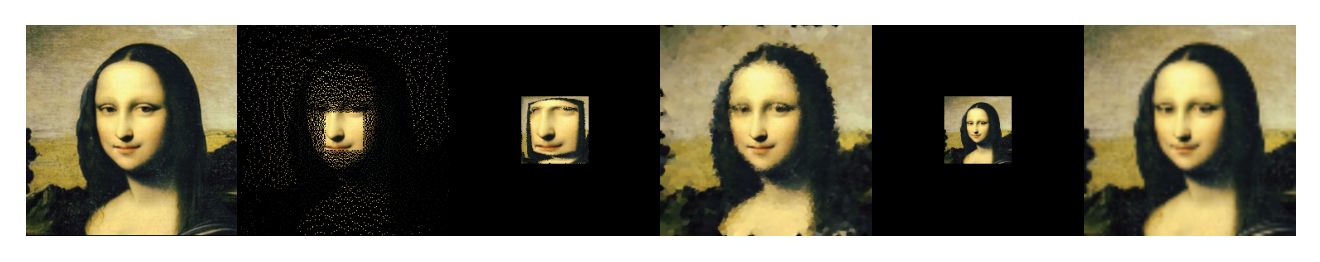

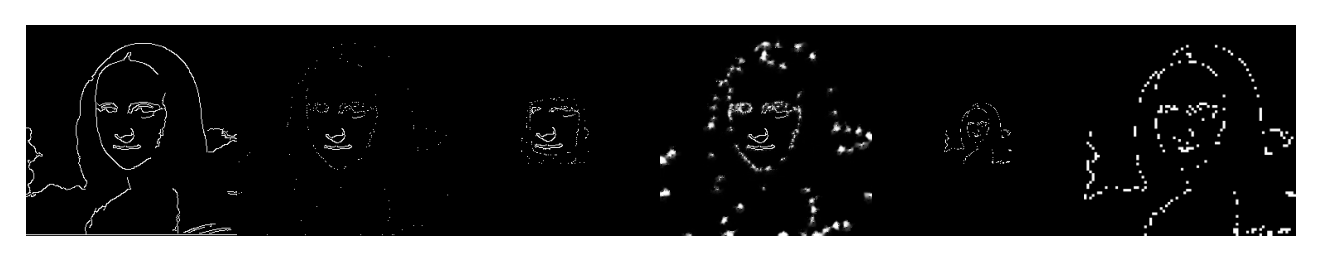

In [22]:
_ = plot_images([sample_image, reconstructed, foveated_image_padded, interpolated, naive_resize_image_padded, naive_upscale_image], num_per_row=6, title=['Sample Image', 'Reconstructed', 'Foveated', 'Interpolated', 'Naive Resize', 'Naive Upscale'])
_ = plot_images([sample_labels, reconstructed_labels, foveated_labels_padded, interpolated_labels, naive_resize_label_padded, naive_upscale_label], num_per_row=6, title=['Sample Label', 'Reconstructed', 'Foveated', 'Interpolated', 'Naive Resize', 'Naive Upscale'])

In [23]:
compressed_shape = foveated_image.shape
original_shape = sample_image.shape

# Percentage of compression
print('Compression ratio: {:.2f}%'.format(100 * (1 - compressed_shape[0] * compressed_shape[1] / (original_shape[0] * original_shape[1]))))

Compression ratio: 89.99%


# Phosphene Simulator

In [24]:
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from dynaphos.dynaphos import utils
from dynaphos.dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.dynaphos.utils import get_data_kwargs, to_numpy

In [25]:
logging.basicConfig(level=logging.INFO)

# read parameters from yaml file
params = utils.load_params('dynaphos\config\params.yaml')
params['thresholding']['use_threshold'] = False

# initialise phopshene locations, either using a cortex model or semi-probabilistically
coordinates_cortex = utils.load_coordinates_from_yaml('dynaphos\config\grid_coords_dipole_valid.yaml', n_coordinates=1024)
coordinates_cortex = Map(*coordinates_cortex)
coordinates_visual_field = get_visual_field_coordinates_from_cortex_full(params['cortex_model'], coordinates_cortex)
r, phi = coordinates_visual_field.polar

# initialise simulator
simulator = PhospheneSimulator(params, coordinates_visual_field)

INFO:root:Removed 6 of 819 phosphene locations.
INFO:root:Removed 7 of 819 phosphene locations.


In [26]:
labels_array = np.array(sample_labels)
img_gray = (labels_array/255).clip(0,1)

interpolated_labels_array = np.array(interpolated_labels)
interpolated_img_gray = (interpolated_labels_array/255).clip(0,1)

naive_upscale_label_array = np.array(naive_upscale_label)
naive_upscale_img_gray = (naive_upscale_label_array/255).clip(0,1)

In [27]:
stim_gray_rf = simulator.sample_stimulus(img_gray)

stim_gray_rf_interpolated = simulator.sample_stimulus(interpolated_img_gray)

stim_gray_rf_naive_upscale = simulator.sample_stimulus(naive_upscale_img_gray)

0.03028561


(-0.5, 255.5, 255.5, -0.5)

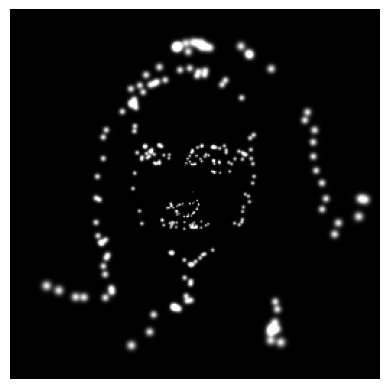

In [28]:
simulator.reset()
phs = to_numpy(simulator(stim_gray_rf))
print(phs.mean())
plt.imshow(phs,cmap='gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

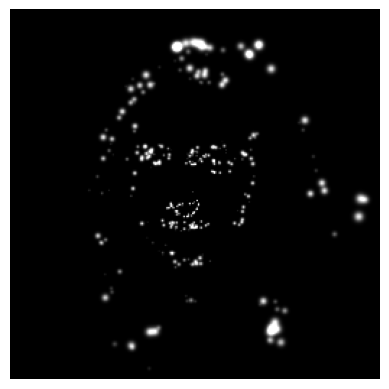

In [29]:
simulator.reset()
phs_interpolated = to_numpy(simulator(stim_gray_rf_interpolated))
plt.imshow(phs_interpolated,cmap='gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

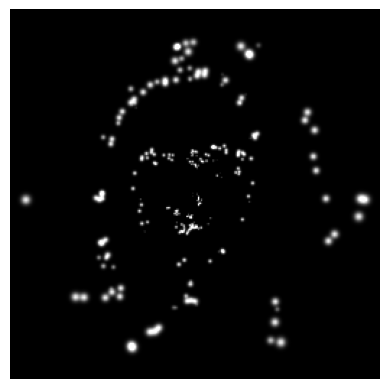

In [30]:
simulator.reset()
phs_interpolated_naive = to_numpy(simulator(stim_gray_rf_naive_upscale))
plt.imshow(phs_interpolated_naive, cmap='gray')
plt.axis('off')

# Final Plots

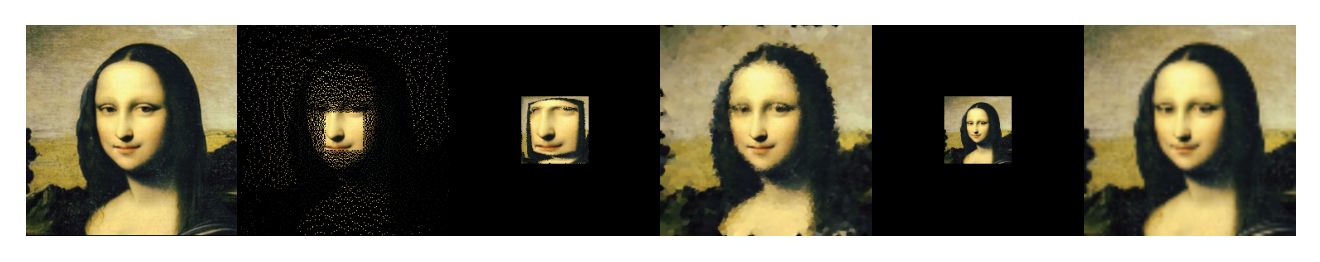

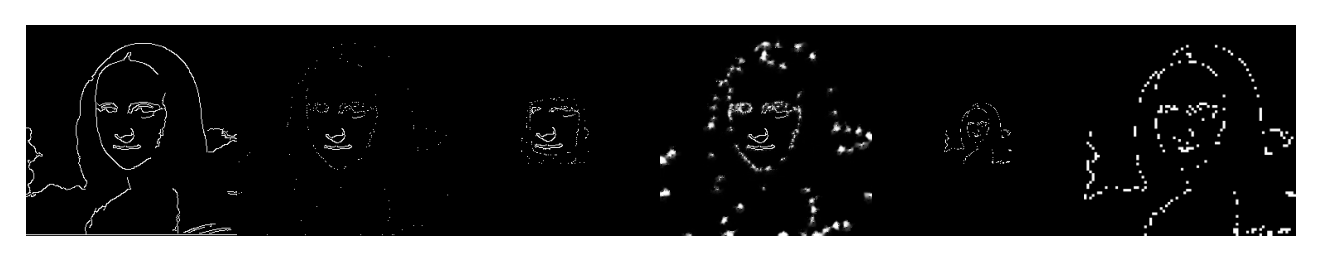

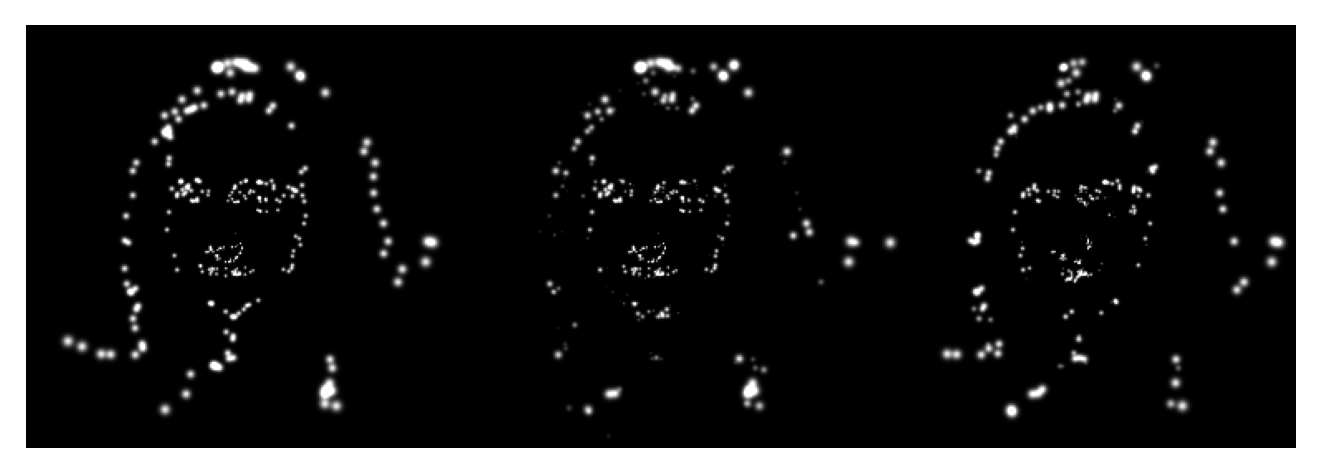

In [31]:
_ = plot_images([sample_image, reconstructed, foveated_image_padded, interpolated, naive_resize_image_padded, naive_upscale_image], num_per_row=6, title=['Sample Image', 'Reconstructed', 'Foveated', 'Interpolated', 'Naive Resize', 'Naive Upscale'])
_ = plot_images([sample_labels, reconstructed_labels, foveated_labels_padded, interpolated_labels, naive_resize_label_padded, naive_upscale_label], num_per_row=6, title=['Sample Label', 'Reconstructed', 'Foveated', 'Interpolated', 'Naive Resize', 'Naive Upscale'])
_ = plot_images([phs, phs_interpolated, phs_interpolated_naive], num_per_row=3)

# Text stuff

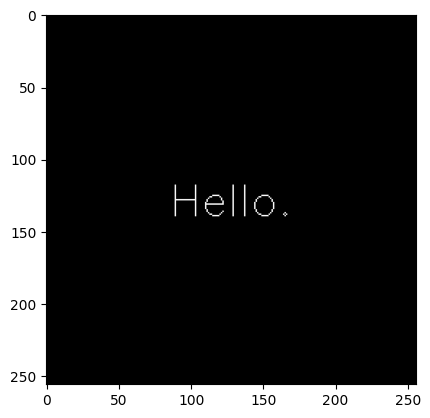

In [32]:
# Create sample image that is completely full of text from top to bottom from left to right
textimg = np.zeros((N,N,3), np.uint8)

# Set the font scale and thickness
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
thickness = 1

# Lorem ipsum
text = "Hello."

# Get the width and height of the text
textsize = cv2.getTextSize(text, font, fontScale, thickness)[0]

# Get the coordinates of the text
textX = (textimg.shape[1] - textsize[0]) // 2
textY = (textimg.shape[0] + textsize[1]) // 2

# Put the text on the image
cv2.putText(textimg, text, (textX, textY), font, fontScale, (255, 255, 255), thickness)


# Display the image
plt.imshow(textimg)
plt.show()

(-0.5, 255.5, 255.5, -0.5)

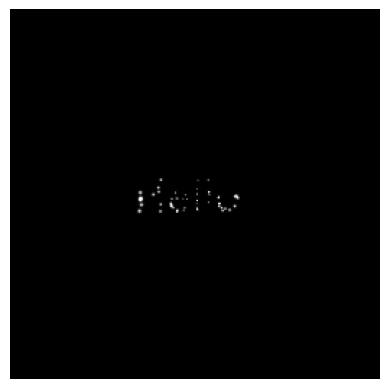

In [33]:
# Do experiment with text image
textimg_gray = cv2.cvtColor(textimg, cv2.COLOR_BGR2GRAY)
textimg_gray = (textimg_gray/255).clip(0,1)

stim_gray_rf_text = simulator.sample_stimulus(textimg_gray)
simulator.reset()
phs_text = to_numpy(simulator(stim_gray_rf_text))
plt.imshow(phs_text,cmap='gray')
plt.axis('off')




(-0.5, 255.5, 255.5, -0.5)

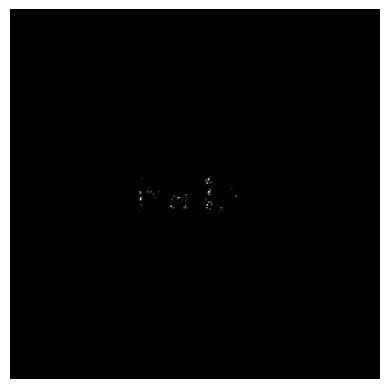

In [34]:
# Do naive resize experiment with text image
naive_resize_textimg = cv2.resize(textimg_gray, (foveated_image.shape[1], foveated_image.shape[0]), interpolation=cv2.INTER_LINEAR)
naive_upscale_textimg = cv2.resize(naive_resize_textimg, (sample_image.shape[1], sample_image.shape[0]), interpolation=cv2.INTER_LINEAR)
stim_gray_rf_naive_resize_text = simulator.sample_stimulus(naive_upscale_textimg)
simulator.reset()
phs_naive_resize_text = to_numpy(simulator(stim_gray_rf_naive_resize_text))
plt.imshow(phs_naive_resize_text,cmap='gray')
plt.axis('off')

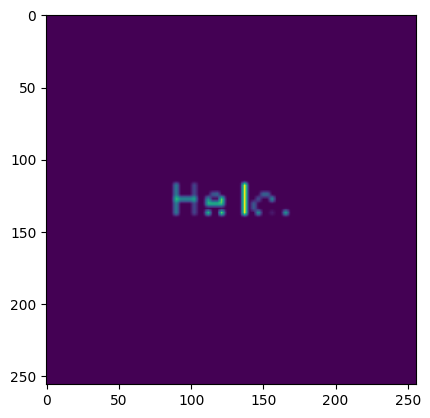

In [35]:
plt.imshow(naive_upscale_textimg)

(81, 81, 3)
(6561,)


(-0.5, 255.5, 255.5, -0.5)

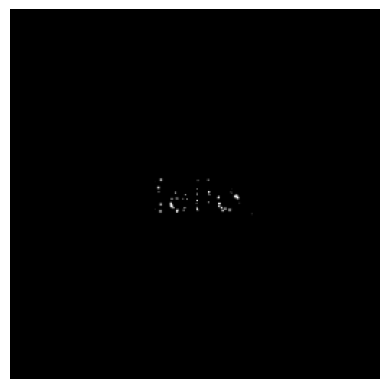

In [36]:
# Do foveated experiment with text image
foveated_textimg = getFovead(textimg, fovX=fovX, fovY=fovY, add_coords=add_coords)
# Interpolated
reconstructed_textimg, interpolated_textimg = getFovead(foveated_textimg, fovX=fovX, fovY=fovY, add_coords=add_coords, reverse=True)

stim_gray_rf_foveated_text = simulator.sample_stimulus(interpolated_textimg[:, :, 0]/255)
simulator.reset()
phs_foveated_text = to_numpy(simulator(stim_gray_rf_foveated_text))
plt.imshow(phs_foveated_text,cmap='gray')
plt.axis('off')


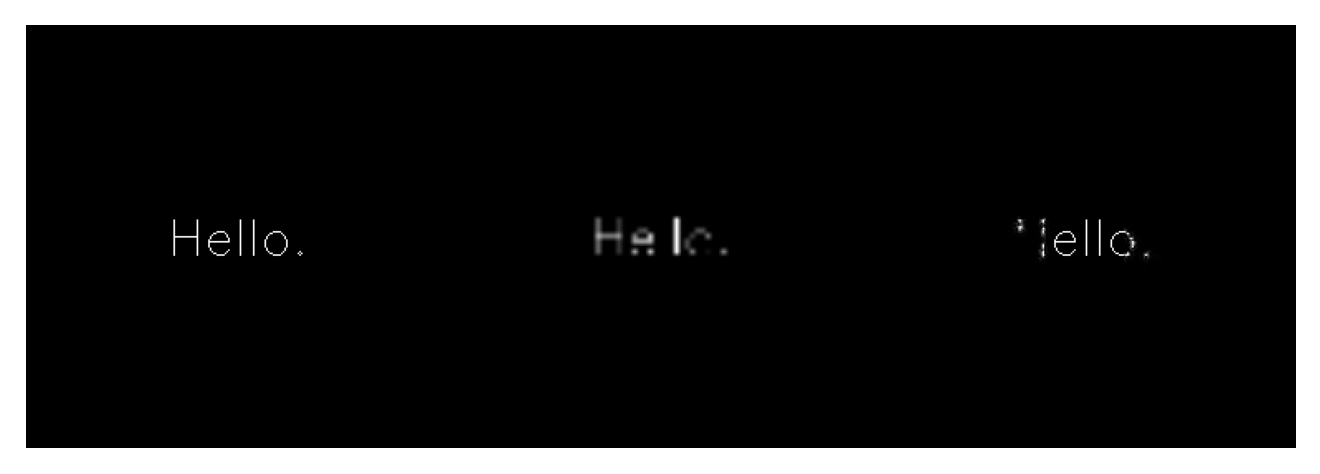

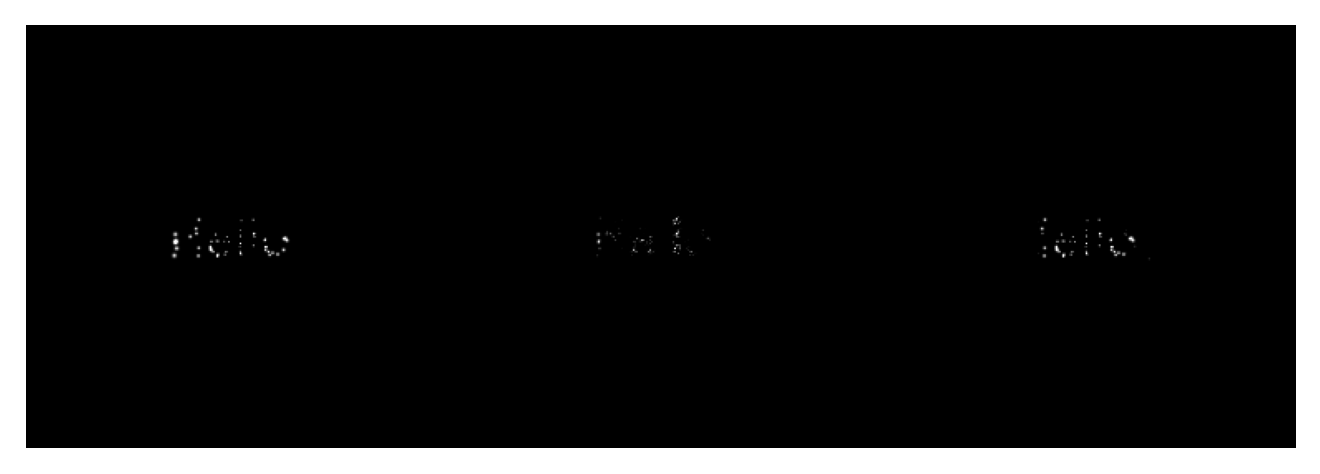

In [37]:
# Show resize results side by side. First original, then naive resize and then foveated
_ = plot_images([textimg, naive_upscale_textimg, interpolated_textimg], num_per_row=3, title=['Original', 'Naive Upscale', 'Foveated'])

# Show phosphene versions
_ = plot_images([phs_text, phs_naive_resize_text, phs_foveated_text], num_per_row=3, title=['Original', 'Naive Upscale', 'Foveated'])